# Logistic classification 

In this notebook, logistic classification (usually called "logistic regerssion", but a classification algorithm) described in Section 4.3 of the book PRML. 

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split

%matplotlib inline
mpl.rc("savefig",dpi=100)

## 1. Setting 

* Let $N \in \mathbb{N}$ be the number of training data points, 
* $d \in \mathbb{N}$ be the dimension of input, 
* $\mathcal{C} = \left\{ 0, 1, \dots, C-1 \right\}$ be the set of class labels, 
* $x_1, x_2, \dots , x_N \in \mathbb{R}^d$ be the training input data, $y_1, y_2, \dots, y_N \in \mathcal{C}$ be the training labels, and
$y := {}^t (y_1, \dots, y_N) \in \mathcal{C}^N$.
* Let $t_n \in \left\{0,1\right\}^{C}$ be the 1-of-$C$ coding of $y_n$, i.e., for $y_n = c$, $t_n$ is a vector with its $c$ th component being 1 and other components being zero. 

## 2. Theory 

### 2.1 Model

We consider the following discriminative model 
$$
\begin{align}
    p(y|x,\theta) = \frac{\exp\left[{\theta^{(y)}}^T \phi(x)\right] }{ \sum_{y'=1}^{C} \exp\left[{\theta^{(y')}}^T \phi(x)\right] }
\end{align}
$$
where
* $\phi : \mathbb{R}^d \rightarrow \mathbb{R}^M $, $\phi(x) = (\phi_0(x), \dots, \phi_{M-1}(x))^T$ are basis functions,  
* $\theta^{(y)} \in \mathbb{R}^M$ are weight parameters, and 
* $\theta = \left( {\theta^{(1)}}^T, \dots, {\theta^{(c)}}^T  \right)^T \in \mathbb{R}^{cM}$

Later, we use "linear" basis function
$$
\begin{align}
    \phi_j(x) = \begin{cases}
        1 & (j=0)\\
        x^{(j-1)} & (j = 1.\dots, d) 
    \end{cases}
\end{align}
$$


Let $\Phi$ be a $N \times M$ matrix defined by
\begin{equation}
    \Phi = (\Phi_{i,j}), \ \ \Phi_{i,j} = \phi_j(x_i)
\end{equation}

### 2.2 Training 

#### 2.2.1 Cost function

In training a logistic classifier, we select the parameter that minimizes the following cost function : 
$$
\begin{align}
    J(\theta) :=  - \frac{1}{N} \sum_{n=0}^{N-1} \sum_{y=0}^{C-1} t_{n,c} \log p_{n,c} + \frac{\lambda}{2N} \| \theta \|^2, 
\end{align}
$$
where 
$$
\begin{align}
    p_{n,c} &:= p(c|x_n,\theta) \\
    t_{n,c} &:= \delta_{y_n, c}
\end{align}
$$
the first term is negative log likelihood, and the second term is a $l^2$ regularization term.

#### 2.2.2 Gradient

To perform the minimization, we need the gradient of the cost function, which is given by 
$$
\begin{align}
    \frac{\partial J}{\partial \theta^{(c)}_{j}} = 
        \frac{1}{N} \sum_{n=0}^{N-1} ( p_{n,c} -  t_{n,c}) \phi_j(x_n) + \frac{\lambda}{N} \theta^{(c)}_{j}
\end{align}
$$

## 3. From math to code

### 3.1 Matrix expression

Here we express cost function and its gradient using a matrix notation. 
The following matrix will be used:
$$
\begin{align}
    & \Phi \ : \ N \times M, \ \ \Phi_{n,m} = \phi_m(x_n) \\
    & \Theta \ : C \times M, \ \ \Theta_{c,j} = \theta^{(c)}_{j} \\
    & T \ : \ N \times C, \ \ T_{n,c} = t_{n,c} \\
    & P \ : \ N \times C, \ \ P_{n,c} = p_{n,c} 
\end{align}
$$
Note that $P$ can be expressed by $\Phi$ and $\Theta$. 

With these definition, we have
$$
\begin{align}
    J(\Theta) 
        &= - \frac{1}{N} \sum_{n=0}^{N-1} \sum_{c=0}^{C-1} t_{n,c} \log p_{n,c} + \frac{\lambda}{2N} \| \theta \|^2  \\
        &= -\frac{1}{N} {\rm Tr}(T^T \log P) + \frac{\lambda}{2N} \| \Theta \|_{2}^{2}
\end{align}
$$
where $\log$ means elementwise log, and 
$$
\begin{align}
    \frac{\partial J(\Theta)}{\partial \Theta}
    &= \left(  \frac{1}{N} \sum_{n=0}^{N-1} ( p_{n,c} -  t_{n,c}) \phi_j(x_n) + \frac{\lambda}{N} \theta^{(c)}_{j} \right)_{c,j} \\
    &= \frac{1}{N} (P-T)^T \Phi + \frac{\lambda}{N} \Theta
\end{align}
$$

In [2]:
class LogisticClf:
    def __init__(self, C, lam):
        self.C = C  # the number of labels
        self.lam = lam #regularization parameter
        
    def genPhimat(self, X):
        '''
        generate the matrix $\Phi$ from X
        '''
        N = len(X)
        if len(np.shape(X)) == 1:
            out = np.zeros((N,2))
            out[:,0] = np.ones(N)
            out[:,1] = X
        else:
            d = np.shape(X)[1]
            out = np.zeros((N,d+1))
            out[:,0] = np.ones(N)
            out[:,1:] = X
        return out

    def genTmat(self, y):
        '''
        generate the matrix $T$ from the training label y
        '''
        N = len(y)
        out = np.zeros((N, self.C))
        c = 0
        for c in range(self.C):
            out[:,c] = (y == c)
        return out

    def genPmat(self, thtmat, phimat):
        out = np.exp( phimat @ (thtmat.T) )
        out = out/np.reshape( np.sum(out, axis= 1), (len(phimat),1)  ) 
        return out
    
    def fit(self, X, y):
        N = len(X)
        phimat = self.genPhimat(X)
        tmat = self.genTmat(y)
        M = len(phimat[0])
        
        # cost function (and its gradient)
        def JandGradJ(thtvec):
            thtmat = np.reshape(thtvec,(self.C, M))
            pmat = self.genPmat(thtmat, phimat)
        
            J = -1.0/N*np.trace( tmat.T @ np.log(pmat) ) + self.lam/(2.0*N)*np.linalg.norm(thtvec)**2
            gradJmat = 1.0/N*((pmat-tmat).T) @ phimat + self.lam/N*thtmat
            gradJvec = np.reshape(gradJmat, len(thtvec))
            return J, gradJvec

        tht0 = np.zeros(M*self.C)
        result = minimize(JandGradJ, tht0, jac = True)
        self.thtmat = np.reshape(result['x'], (self.C, M))
        
    def predict_prob(self, Xtest):
        return self.genPmat(self.thtmat, self.genPhimat(Xtest))
        
    def predict(self, Xtest):
        tmp = self.predict_prob(Xtest)
        return np.argmax(tmp, axis = 1 )

## 4. Experiment

### 4.1 Toy data

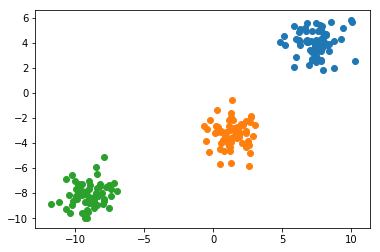

In [3]:
X, y = datasets.make_blobs(200, 2, 3)
for c in range(3):
    plt.plot(X[:,0][y==c], X[:,1][y==c], 'o', label=f'{c}')
plt.show()

xx = np.linspace(np.min(X[:,0]), np.max(X[:,0]),101)
yy = np.linspace(np.min(X[:,1]), np.max(X[:,1]),100)
Xtest = np.array([[x,y] for x in xx  for y in yy])
xxx,yyy = np.meshgrid(xx, yy)

def plot_result(clf, C):
    for c in range(C):
        plt.plot(X[:,0][y==c], X[:,1][y==c],"o",label=f"{c}")
    plt.legend()
    pred_val = clf.predict(Xtest)
    pred_val_2D = np.reshape(pred_val, (len(xx), len(yy))).T
    plt.pcolormesh(xxx, yyy, pred_val_2D)
    plt.colorbar()
    plt.show()

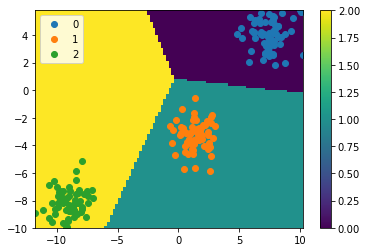

In [4]:
clf = LogisticClf(C = 3, lam = 0.01)
clf.fit(X, y)
plot_result(clf, 3)

### 4.2 Hand-written digits

In [5]:
digits = datasets.load_digits()
dat_train, dat_test, label_train, label_test = train_test_split(digits.data, digits.target, test_size=0.25)

print(f"Training data : {len(dat_train)}")
print(f"Test data : {len(dat_test)}")

Training data : 1347
Test data : 450


In [6]:
clf2 = LogisticClf(C = 10, lam = 0.01)
clf2.fit(dat_train, label_train)
label_test_pred = clf2.predict(dat_test)
ac_score = metrics.accuracy_score(label_test, label_test_pred)
cl_report = metrics.classification_report(label_test, label_test_pred)
print(ac_score)
print(cl_report)

0.955555555556
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        38
          1       0.92      0.90      0.91        50
          2       1.00      1.00      1.00        43
          3       0.95      0.95      0.95        42
          4       0.97      1.00      0.98        56
          5       0.94      0.92      0.93        48
          6       1.00      0.96      0.98        54
          7       0.95      0.93      0.94        41
          8       0.95      0.93      0.94        43
          9       0.87      0.97      0.92        35

avg / total       0.96      0.96      0.96       450

